In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

2023-12-13 16:18:22.970986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [3]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [5]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [6]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [7]:
from keras.applications import VGG19

In [8]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [9]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [15]:
n=1000
lr_list = os.listdir("/Users/akshat/GAN/lr_images/")[2000:2000+n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/Users/akshat/GAN/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/Users/akshat/GAN/hr_images/")[2000:2000+n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/Users/akshat/GAN/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

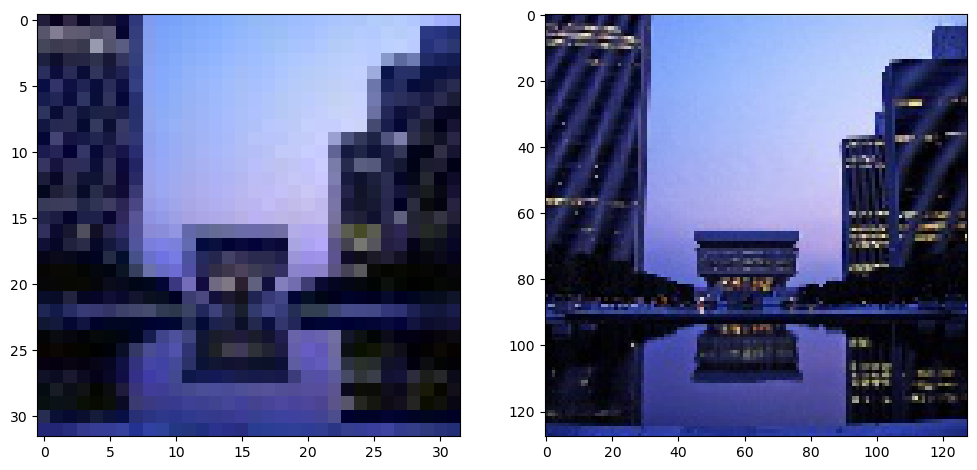

In [16]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [69]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.


In [67]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [19]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [20]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
generator.summary()

2023-12-13 16:19:44.182128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 64)   36928       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_6 (PReLU)              (None, 32, 32, 64)   64          ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_6[0][0]']              
                                                                                                  
 batch_nor

 conv2d_22 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_11[0][0]']             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_10 (Add)                   (None, 32, 32, 64)   0           ['add_9[0][0]',                  
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 64)   36928       ['add_10[0][0]']                 
                                                                                                  
 batch_nor

 conv2d_33 (Conv2D)             (None, 32, 32, 64)   36928       ['add_15[0][0]']                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 32, 32, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 32, 32, 64)   0           ['batch_normalization_32[0][0]', 
                                                                  'p_re_lu[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 256)  147712      ['add_16[0][0]']                 
                                                                                                  
 up_sampli

In [21]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [22]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [23]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [24]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [25]:
#Create a list of images for LR and HR in batches from which a batch of images would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
epochs = 10

    

In [27]:
import pickle
generator.load_weights('g_w_15.h5')
generator.make_train_function()
with open('g_o_15.pkl', 'rb') as f:
    weight_values = pickle.load(f)
generator.optimizer.set_weights(weight_values)

In [28]:
import pickle

# Save optimizer weights
optimizer_weights = discriminator.optimizer.get_weights()
with open('d_o_w.pkl', 'wb') as f:
    pickle.dump(optimizer_weights, f)


In [29]:
# Load optimizer weights
with open('d_o_w.pkl', 'rb') as f:
    optimizer_weights = pickle.load(f)

# Set optimizer weights
discriminator.optimizer.set_weights(optimizer_weights)


In [24]:
import keras.backend as K
import pickle

for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("g_13.h5",include_optimizer=True)
        discriminator.save("d_13.h5",include_optimizer=True)
        
        generator.save_weights('g_w_13.h5')
        discriminator.save_weights('d_w_13.h5')
        
        symbolic_weights = getattr(generator.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        with open('g_o_13.pkl', 'wb') as f:
            pickle.dump(weight_values, f)
        
        symbolic_weights = getattr(discriminator.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        with open('d_o_13.pkl', 'wb') as f:
            pickle.dump(weight_values, f)
        
        

        

  0%|                                                   | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  1%|▎                                          | 1/134 [00:06<14:20,  6.47s/it]

1/1 [==============================] - 0s 98ms/step


  1%|▋                                          | 2/134 [00:08<08:02,  3.66s/it]

1/1 [==============================] - 0s 67ms/step


  2%|▉                                          | 3/134 [00:09<05:46,  2.64s/it]

1/1 [==============================] - 0s 66ms/step


  3%|█▎                                         | 4/134 [00:11<04:40,  2.16s/it]

1/1 [==============================] - 0s 66ms/step


  4%|█▌                                         | 5/134 [00:12<04:03,  1.89s/it]

1/1 [==============================] - 0s 69ms/step


  4%|█▉                                         | 6/134 [00:13<03:42,  1.73s/it]

1/1 [==============================] - 0s 67ms/step


  5%|██▏                                        | 7/134 [00:15<03:27,  1.63s/it]

1/1 [==============================] - 0s 65ms/step


  6%|██▌                                        | 8/134 [00:16<03:16,  1.56s/it]

1/1 [==============================] - 0s 66ms/step


  7%|██▉                                        | 9/134 [00:18<03:09,  1.52s/it]

1/1 [==============================] - 0s 79ms/step


  7%|███▏                                      | 10/134 [00:19<03:08,  1.52s/it]

1/1 [==============================] - 0s 67ms/step


  8%|███▍                                      | 11/134 [00:21<03:03,  1.49s/it]

1/1 [==============================] - 0s 66ms/step


  9%|███▊                                      | 12/134 [00:22<02:59,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 10%|████                                      | 13/134 [00:23<02:56,  1.46s/it]

1/1 [==============================] - 0s 65ms/step


 10%|████▍                                     | 14/134 [00:25<02:53,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 11%|████▋                                     | 15/134 [00:26<02:51,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


 12%|█████                                     | 16/134 [00:28<02:49,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 13%|█████▎                                    | 17/134 [00:29<02:47,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 13%|█████▋                                    | 18/134 [00:31<02:45,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 14%|█████▉                                    | 19/134 [00:32<02:44,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 15%|██████▎                                   | 20/134 [00:33<02:42,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 16%|██████▌                                   | 21/134 [00:35<02:43,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 16%|██████▉                                   | 22/134 [00:36<02:41,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 17%|███████▏                                  | 23/134 [00:38<02:39,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 18%|███████▌                                  | 24/134 [00:39<02:37,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 19%|███████▊                                  | 25/134 [00:41<02:36,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 19%|████████▏                                 | 26/134 [00:42<02:34,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 20%|████████▍                                 | 27/134 [00:43<02:32,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 21%|████████▊                                 | 28/134 [00:45<02:31,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 22%|█████████                                 | 29/134 [00:46<02:29,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 22%|█████████▍                                | 30/134 [00:48<02:27,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 23%|█████████▋                                | 31/134 [00:49<02:27,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 24%|██████████                                | 32/134 [00:51<02:27,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 25%|██████████▎                               | 33/134 [00:52<02:24,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 25%|██████████▋                               | 34/134 [00:53<02:22,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 26%|██████████▉                               | 35/134 [00:55<02:21,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 27%|███████████▎                              | 36/134 [00:56<02:19,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 28%|███████████▌                              | 37/134 [00:58<02:18,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 28%|███████████▉                              | 38/134 [00:59<02:16,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 29%|████████████▏                             | 39/134 [01:01<02:15,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 30%|████████████▌                             | 40/134 [01:02<02:13,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 31%|████████████▊                             | 41/134 [01:03<02:11,  1.41s/it]

1/1 [==============================] - 0s 68ms/step


 31%|█████████████▏                            | 42/134 [01:05<02:09,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 32%|█████████████▍                            | 43/134 [01:06<02:08,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 33%|█████████████▊                            | 44/134 [01:08<02:08,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 34%|██████████████                            | 45/134 [01:09<02:06,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 34%|██████████████▍                           | 46/134 [01:10<02:04,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 35%|██████████████▋                           | 47/134 [01:12<02:02,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 36%|███████████████                           | 48/134 [01:13<02:01,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███████████████▎                          | 49/134 [01:15<01:59,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███████████████▋                          | 50/134 [01:16<01:59,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 38%|███████████████▉                          | 51/134 [01:17<01:57,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 39%|████████████████▎                         | 52/134 [01:19<01:55,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 40%|████████████████▌                         | 53/134 [01:20<01:54,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 40%|████████████████▉                         | 54/134 [01:22<01:52,  1.41s/it]

1/1 [==============================] - 0s 79ms/step


 41%|█████████████████▏                        | 55/134 [01:23<01:53,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 42%|█████████████████▌                        | 56/134 [01:25<01:51,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 43%|█████████████████▊                        | 57/134 [01:26<01:49,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 43%|██████████████████▏                       | 58/134 [01:27<01:47,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████▍                       | 59/134 [01:29<01:46,  1.41s/it]

1/1 [==============================] - 0s 68ms/step


 45%|██████████████████▊                       | 60/134 [01:30<01:44,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 46%|███████████████████                       | 61/134 [01:32<01:42,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 46%|███████████████████▍                      | 62/134 [01:33<01:41,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 47%|███████████████████▋                      | 63/134 [01:34<01:39,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 48%|████████████████████                      | 64/134 [01:36<01:38,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 49%|████████████████████▎                     | 65/134 [01:37<01:37,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 49%|████████████████████▋                     | 66/134 [01:39<01:37,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 50%|█████████████████████                     | 67/134 [01:40<01:35,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 51%|█████████████████████▎                    | 68/134 [01:42<01:33,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 51%|█████████████████████▋                    | 69/134 [01:43<01:32,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 52%|█████████████████████▉                    | 70/134 [01:44<01:30,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 53%|██████████████████████▎                   | 71/134 [01:46<01:29,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 54%|██████████████████████▌                   | 72/134 [01:47<01:27,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████▉                   | 73/134 [01:49<01:26,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 55%|███████████████████████▏                  | 74/134 [01:50<01:24,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████▌                  | 75/134 [01:51<01:23,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 57%|███████████████████████▊                  | 76/134 [01:53<01:21,  1.41s/it]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████▏                 | 77/134 [01:54<01:21,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 58%|████████████████████████▍                 | 78/134 [01:56<01:20,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 59%|████████████████████████▊                 | 79/134 [01:57<01:18,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 60%|█████████████████████████                 | 80/134 [01:59<01:16,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 60%|█████████████████████████▍                | 81/134 [02:00<01:15,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 61%|█████████████████████████▋                | 82/134 [02:01<01:14,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 62%|██████████████████████████                | 83/134 [02:03<01:12,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 63%|██████████████████████████▎               | 84/134 [02:04<01:11,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 63%|██████████████████████████▋               | 85/134 [02:06<01:09,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 64%|██████████████████████████▉               | 86/134 [02:07<01:08,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 65%|███████████████████████████▎              | 87/134 [02:09<01:06,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████▌              | 88/134 [02:10<01:06,  1.45s/it]

1/1 [==============================] - 0s 73ms/step


 66%|███████████████████████████▉              | 89/134 [02:12<01:17,  1.72s/it]

1/1 [==============================] - 0s 69ms/step


 67%|████████████████████████████▏             | 90/134 [02:14<01:13,  1.66s/it]

1/1 [==============================] - 0s 69ms/step


 68%|████████████████████████████▌             | 91/134 [02:15<01:08,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 69%|████████████████████████████▊             | 92/134 [05:01<35:35, 50.84s/it]

1/1 [==============================] - 0s 67ms/step


 69%|█████████████████████████████▏            | 93/134 [05:03<24:36, 36.02s/it]

1/1 [==============================] - 0s 67ms/step


 70%|█████████████████████████████▍            | 94/134 [05:04<17:06, 25.66s/it]

1/1 [==============================] - 0s 67ms/step


 71%|█████████████████████████████▊            | 95/134 [05:06<11:58, 18.42s/it]

1/1 [==============================] - 0s 87ms/step


 72%|██████████████████████████████            | 96/134 [05:07<08:30, 13.43s/it]

1/1 [==============================] - 0s 83ms/step


 72%|██████████████████████████████▍           | 97/134 [05:09<06:08,  9.95s/it]

1/1 [==============================] - 0s 71ms/step


 73%|██████████████████████████████▋           | 98/134 [05:11<04:27,  7.44s/it]

1/1 [==============================] - 0s 67ms/step


 74%|███████████████████████████████           | 99/134 [05:12<03:17,  5.64s/it]

1/1 [==============================] - 0s 65ms/step


 75%|██████████████████████████████▌          | 100/134 [05:14<02:28,  4.37s/it]

1/1 [==============================] - 0s 67ms/step


 75%|██████████████████████████████▉          | 101/134 [05:15<01:54,  3.48s/it]

1/1 [==============================] - 0s 68ms/step


 76%|███████████████████████████████▏         | 102/134 [05:16<01:31,  2.87s/it]

1/1 [==============================] - 0s 65ms/step


 77%|███████████████████████████████▌         | 103/134 [05:18<01:15,  2.43s/it]

1/1 [==============================] - 0s 67ms/step


 78%|███████████████████████████████▊         | 104/134 [05:19<01:04,  2.14s/it]

1/1 [==============================] - 0s 68ms/step


 78%|████████████████████████████████▏        | 105/134 [05:21<00:55,  1.92s/it]

1/1 [==============================] - 0s 71ms/step


 79%|████████████████████████████████▍        | 106/134 [05:22<00:49,  1.78s/it]

1/1 [==============================] - 0s 66ms/step


 80%|████████████████████████████████▋        | 107/134 [05:24<00:45,  1.68s/it]

1/1 [==============================] - 0s 66ms/step


 81%|█████████████████████████████████        | 108/134 [05:25<00:41,  1.60s/it]

1/1 [==============================] - 0s 67ms/step


 81%|█████████████████████████████████▎       | 109/134 [05:27<00:38,  1.56s/it]

1/1 [==============================] - 0s 66ms/step


 82%|█████████████████████████████████▋       | 110/134 [05:28<00:36,  1.52s/it]

1/1 [==============================] - 0s 68ms/step


 83%|█████████████████████████████████▉       | 111/134 [05:29<00:34,  1.49s/it]

1/1 [==============================] - 0s 67ms/step


 84%|██████████████████████████████████▎      | 112/134 [05:31<00:32,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 84%|██████████████████████████████████▌      | 113/134 [05:32<00:30,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 85%|██████████████████████████████████▉      | 114/134 [05:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 86%|███████████████████████████████████▏     | 115/134 [05:35<00:27,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 87%|███████████████████████████████████▍     | 116/134 [05:36<00:25,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 87%|███████████████████████████████████▊     | 117/134 [05:38<00:24,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 88%|████████████████████████████████████     | 118/134 [05:39<00:22,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 89%|████████████████████████████████████▍    | 119/134 [05:41<00:21,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 90%|████████████████████████████████████▋    | 120/134 [05:42<00:20,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 90%|█████████████████████████████████████    | 121/134 [05:44<00:18,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 91%|█████████████████████████████████████▎   | 122/134 [05:45<00:17,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████▋   | 123/134 [05:46<00:15,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 93%|█████████████████████████████████████▉   | 124/134 [05:48<00:14,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 93%|██████████████████████████████████████▏  | 125/134 [05:49<00:12,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 94%|██████████████████████████████████████▌  | 126/134 [05:51<00:11,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 95%|██████████████████████████████████████▊  | 127/134 [05:52<00:09,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 96%|███████████████████████████████████████▏ | 128/134 [05:54<00:08,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 96%|███████████████████████████████████████▍ | 129/134 [05:55<00:07,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 97%|███████████████████████████████████████▊ | 130/134 [05:56<00:05,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 98%|████████████████████████████████████████ | 131/134 [05:58<00:04,  1.41s/it]

1/1 [==============================] - 0s 78ms/step


 99%|████████████████████████████████████████▍| 132/134 [05:59<00:02,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 99%|████████████████████████████████████████▋| 133/134 [06:01<00:01,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


100%|█████████████████████████████████████████| 134/134 [06:02<00:00,  2.71s/it]


epoch: 1 g_loss: 22.256349492428907 d_loss: [9.99174721 0.46268657]


  0%|                                                   | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▎                                          | 1/134 [00:01<03:09,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


  1%|▋                                          | 2/134 [00:02<03:08,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


  2%|▉                                          | 3/134 [00:04<03:05,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


  3%|█▎                                         | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


  4%|█▌                                         | 5/134 [00:07<03:01,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


  4%|█▉                                         | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


  5%|██▏                                        | 7/134 [00:09<02:58,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


  6%|██▌                                        | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 76ms/step


  7%|██▉                                        | 9/134 [00:12<02:59,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


  7%|███▏                                      | 10/134 [00:14<02:57,  1.43s/it]

1/1 [==============================] - 0s 65ms/step


  8%|███▍                                      | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


  9%|███▊                                      | 12/134 [00:16<02:52,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 10%|████                                      | 13/134 [00:18<02:50,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 10%|████▍                                     | 14/134 [00:19<02:49,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 11%|████▋                                     | 15/134 [00:21<02:48,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 12%|█████                                     | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 13%|█████▎                                    | 17/134 [00:24<02:44,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 13%|█████▋                                    | 18/134 [00:25<02:43,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 14%|█████▉                                    | 19/134 [00:26<02:42,  1.41s/it]

1/1 [==============================] - 0s 68ms/step


 15%|██████▎                                   | 20/134 [00:28<02:44,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 16%|██████▌                                   | 21/134 [00:29<02:41,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 16%|██████▉                                   | 22/134 [00:31<02:40,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 17%|███████▏                                  | 23/134 [00:32<02:38,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 18%|███████▌                                  | 24/134 [00:34<02:35,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 19%|███████▊                                  | 25/134 [00:35<02:33,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


 19%|████████▏                                 | 26/134 [00:36<02:31,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 20%|████████▍                                 | 27/134 [00:38<02:30,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 21%|████████▊                                 | 28/134 [00:39<02:29,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 22%|█████████                                 | 29/134 [00:41<02:27,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 22%|█████████▍                                | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 23%|█████████▋                                | 31/134 [00:43<02:25,  1.41s/it]

1/1 [==============================] - 0s 79ms/step


 24%|██████████                                | 32/134 [00:45<02:26,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 25%|██████████▎                               | 33/134 [00:46<02:23,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 25%|██████████▋                               | 34/134 [00:48<02:22,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 26%|██████████▉                               | 35/134 [00:49<02:21,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 27%|███████████▎                              | 36/134 [00:51<02:19,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 28%|███████████▌                              | 37/134 [00:52<02:17,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 28%|███████████▉                              | 38/134 [00:53<02:16,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 29%|████████████▏                             | 39/134 [00:55<02:14,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 30%|████████████▌                             | 40/134 [00:56<02:14,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 31%|████████████▊                             | 41/134 [00:58<02:12,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 31%|█████████████▏                            | 42/134 [00:59<02:12,  1.44s/it]

1/1 [==============================] - 0s 80ms/step


 32%|█████████████▍                            | 43/134 [01:01<02:16,  1.50s/it]

1/1 [==============================] - 0s 74ms/step


 33%|█████████████▊                            | 44/134 [01:02<02:16,  1.52s/it]

1/1 [==============================] - 0s 67ms/step


 34%|██████████████                            | 45/134 [01:04<02:13,  1.50s/it]

1/1 [==============================] - 0s 68ms/step


 34%|██████████████▍                           | 46/134 [01:05<02:09,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 35%|██████████████▋                           | 47/134 [01:07<02:06,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 36%|███████████████                           | 48/134 [01:08<02:04,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███████████████▎                          | 49/134 [01:09<02:02,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 37%|███████████████▋                          | 50/134 [01:11<02:00,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 38%|███████████████▉                          | 51/134 [01:12<01:58,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 39%|████████████████▎                         | 52/134 [01:14<01:56,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 40%|████████████████▌                         | 53/134 [01:15<01:54,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 40%|████████████████▉                         | 54/134 [01:17<01:56,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 41%|█████████████████▏                        | 55/134 [01:18<01:53,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 42%|█████████████████▌                        | 56/134 [01:19<01:51,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 43%|█████████████████▊                        | 57/134 [01:21<01:49,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 43%|██████████████████▏                       | 58/134 [01:22<01:47,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████▍                       | 59/134 [01:24<01:46,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 45%|██████████████████▊                       | 60/134 [01:25<01:45,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████                       | 61/134 [01:27<01:43,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 46%|███████████████████▍                      | 62/134 [01:28<01:41,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 47%|███████████████████▋                      | 63/134 [01:29<01:40,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 48%|████████████████████                      | 64/134 [01:31<01:39,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 49%|████████████████████▎                     | 65/134 [01:32<01:39,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 49%|████████████████████▋                     | 66/134 [01:34<01:37,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 50%|█████████████████████                     | 67/134 [01:35<01:35,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 51%|█████████████████████▎                    | 68/134 [01:37<01:34,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 51%|█████████████████████▋                    | 69/134 [01:38<01:33,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 52%|█████████████████████▉                    | 70/134 [01:39<01:32,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 53%|██████████████████████▎                   | 71/134 [01:41<01:30,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 54%|██████████████████████▌                   | 72/134 [01:42<01:28,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 54%|██████████████████████▉                   | 73/134 [01:44<01:27,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 55%|███████████████████████▏                  | 74/134 [01:45<01:25,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████▌                  | 75/134 [01:47<01:24,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 57%|███████████████████████▊                  | 76/134 [01:48<01:24,  1.46s/it]

1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████▏                 | 77/134 [01:50<01:22,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


 58%|████████████████████████▍                 | 78/134 [01:51<01:20,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 59%|████████████████████████▊                 | 79/134 [01:52<01:18,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 60%|█████████████████████████                 | 80/134 [01:54<01:17,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 60%|█████████████████████████▍                | 81/134 [01:55<01:15,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 61%|█████████████████████████▋                | 82/134 [01:57<01:13,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 62%|██████████████████████████                | 83/134 [01:58<01:12,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 63%|██████████████████████████▎               | 84/134 [01:59<01:10,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 63%|██████████████████████████▋               | 85/134 [02:01<01:10,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 64%|██████████████████████████▉               | 86/134 [02:02<01:08,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 65%|███████████████████████████▎              | 87/134 [02:04<01:07,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████▌              | 88/134 [02:05<01:06,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████▉              | 89/134 [02:07<01:04,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████▏             | 90/134 [02:08<01:03,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 68%|████████████████████████████▌             | 91/134 [02:10<01:01,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 69%|████████████████████████████▊             | 92/134 [02:11<00:59,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 69%|█████████████████████████████▏            | 93/134 [02:12<00:58,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 70%|█████████████████████████████▍            | 94/134 [02:14<00:56,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 71%|█████████████████████████████▊            | 95/134 [02:15<00:55,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 72%|██████████████████████████████            | 96/134 [02:17<00:53,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 72%|██████████████████████████████▍           | 97/134 [02:18<00:52,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 73%|██████████████████████████████▋           | 98/134 [02:20<00:51,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 74%|███████████████████████████████           | 99/134 [02:21<00:50,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 75%|██████████████████████████████▌          | 100/134 [02:22<00:49,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 75%|██████████████████████████████▉          | 101/134 [02:24<00:47,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 76%|███████████████████████████████▏         | 102/134 [02:25<00:46,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 77%|███████████████████████████████▌         | 103/134 [02:27<00:44,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 78%|███████████████████████████████▊         | 104/134 [02:28<00:43,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 78%|████████████████████████████████▏        | 105/134 [02:30<00:41,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 79%|████████████████████████████████▍        | 106/134 [02:31<00:39,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 80%|████████████████████████████████▋        | 107/134 [02:32<00:38,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 81%|█████████████████████████████████        | 108/134 [02:34<00:36,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 81%|█████████████████████████████████▎       | 109/134 [02:35<00:35,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████▋       | 110/134 [02:37<00:34,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 83%|█████████████████████████████████▉       | 111/134 [02:38<00:33,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 84%|██████████████████████████████████▎      | 112/134 [02:40<00:31,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 84%|██████████████████████████████████▌      | 113/134 [02:41<00:30,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 85%|██████████████████████████████████▉      | 114/134 [02:42<00:28,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 86%|███████████████████████████████████▏     | 115/134 [02:44<00:27,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 87%|███████████████████████████████████▍     | 116/134 [02:45<00:25,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 87%|███████████████████████████████████▊     | 117/134 [02:47<00:24,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 88%|████████████████████████████████████     | 118/134 [02:48<00:22,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 89%|████████████████████████████████████▍    | 119/134 [02:50<00:21,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 90%|████████████████████████████████████▋    | 120/134 [02:51<00:19,  1.42s/it]

1/1 [==============================] - 0s 80ms/step


 90%|█████████████████████████████████████    | 121/134 [02:52<00:18,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 91%|█████████████████████████████████████▎   | 122/134 [02:54<00:17,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████▋   | 123/134 [02:55<00:15,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 93%|█████████████████████████████████████▉   | 124/134 [02:57<00:14,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 93%|██████████████████████████████████████▏  | 125/134 [02:58<00:12,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 94%|██████████████████████████████████████▌  | 126/134 [03:00<00:11,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 95%|██████████████████████████████████████▊  | 127/134 [03:01<00:09,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 96%|███████████████████████████████████████▏ | 128/134 [03:02<00:08,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 96%|███████████████████████████████████████▍ | 129/134 [03:04<00:07,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 97%|███████████████████████████████████████▊ | 130/134 [03:05<00:05,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 98%|████████████████████████████████████████ | 131/134 [03:07<00:04,  1.43s/it]

1/1 [==============================] - 0s 76ms/step


 99%|████████████████████████████████████████▍| 132/134 [03:08<00:02,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 99%|████████████████████████████████████████▋| 133/134 [03:10<00:01,  1.46s/it]

1/1 [==============================] - 0s 69ms/step


100%|█████████████████████████████████████████| 134/134 [03:11<00:00,  1.43s/it]


epoch: 2 g_loss: 19.474834370968946 d_loss: [1.69223433 0.47014925]


  0%|                                                   | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▎                                          | 1/134 [00:01<03:16,  1.48s/it]

1/1 [==============================] - 0s 69ms/step


  1%|▋                                          | 2/134 [00:02<03:11,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


  2%|▉                                          | 3/134 [00:04<03:09,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


  3%|█▎                                         | 4/134 [00:05<03:07,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


  4%|█▌                                         | 5/134 [00:07<03:06,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


  4%|█▉                                         | 6/134 [00:54<36:30, 17.12s/it]

1/1 [==============================] - 0s 77ms/step


  5%|██▏                                        | 7/134 [00:56<25:34, 12.09s/it]

1/1 [==============================] - 0s 75ms/step


  6%|██▌                                        | 8/134 [00:58<18:22,  8.75s/it]

1/1 [==============================] - 0s 67ms/step


  7%|██▉                                        | 9/134 [00:59<13:30,  6.48s/it]

1/1 [==============================] - 0s 68ms/step


  7%|███▏                                      | 10/134 [01:01<10:11,  4.93s/it]

1/1 [==============================] - 0s 67ms/step


  8%|███▍                                      | 11/134 [01:02<07:55,  3.87s/it]

1/1 [==============================] - 0s 68ms/step


  9%|███▊                                      | 12/134 [01:03<06:20,  3.12s/it]

1/1 [==============================] - 0s 66ms/step


 10%|████                                      | 13/134 [01:05<05:15,  2.61s/it]

1/1 [==============================] - 0s 65ms/step


 10%|████▍                                     | 14/134 [01:06<04:29,  2.24s/it]

1/1 [==============================] - 0s 67ms/step


 11%|████▋                                     | 15/134 [01:08<03:56,  1.99s/it]

1/1 [==============================] - 0s 69ms/step


 12%|█████                                     | 16/134 [01:09<03:33,  1.81s/it]

1/1 [==============================] - 0s 67ms/step


 13%|█████▎                                    | 17/134 [01:11<03:21,  1.72s/it]

1/1 [==============================] - 0s 68ms/step


 13%|█████▋                                    | 18/134 [01:12<03:11,  1.65s/it]

1/1 [==============================] - 0s 67ms/step


 14%|█████▉                                    | 19/134 [01:14<03:04,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 15%|██████▎                                   | 20/134 [01:15<02:58,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 16%|██████▌                                   | 21/134 [01:16<02:51,  1.52s/it]

1/1 [==============================] - 0s 66ms/step


 16%|██████▉                                   | 22/134 [01:18<02:47,  1.50s/it]

1/1 [==============================] - 0s 66ms/step


 17%|███████▏                                  | 23/134 [01:19<02:44,  1.48s/it]

1/1 [==============================] - 0s 67ms/step


 18%|███████▌                                  | 24/134 [01:21<02:40,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 19%|███████▊                                  | 25/134 [01:22<02:38,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 19%|████████▏                                 | 26/134 [01:24<02:35,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 20%|████████▍                                 | 27/134 [01:25<02:33,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 21%|████████▊                                 | 28/134 [01:26<02:31,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 22%|█████████                                 | 29/134 [01:28<02:30,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 22%|█████████▍                                | 30/134 [01:29<02:28,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 23%|█████████▋                                | 31/134 [01:31<02:29,  1.45s/it]

1/1 [==============================] - 0s 69ms/step


 24%|██████████                                | 32/134 [01:32<02:27,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 25%|██████████▎                               | 33/134 [01:34<02:24,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 25%|██████████▋                               | 34/134 [01:35<02:22,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 26%|██████████▉                               | 35/134 [01:36<02:21,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 27%|███████████▎                              | 36/134 [01:38<02:19,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 28%|███████████▌                              | 37/134 [01:39<02:18,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 28%|███████████▉                              | 38/134 [01:41<02:16,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 29%|████████████▏                             | 39/134 [01:42<02:15,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 30%|████████████▌                             | 40/134 [01:44<02:13,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 31%|████████████▊                             | 41/134 [01:45<02:12,  1.43s/it]

1/1 [==============================] - 0s 76ms/step


 31%|█████████████▏                            | 42/134 [01:47<02:14,  1.46s/it]

1/1 [==============================] - 0s 69ms/step


 32%|█████████████▍                            | 43/134 [01:48<02:12,  1.45s/it]

1/1 [==============================] - 0s 71ms/step


 33%|█████████████▊                            | 44/134 [01:50<02:12,  1.47s/it]

1/1 [==============================] - 0s 76ms/step


 34%|██████████████                            | 45/134 [01:51<02:11,  1.48s/it]

1/1 [==============================] - 0s 71ms/step


 34%|██████████████▍                           | 46/134 [01:53<02:11,  1.49s/it]

1/1 [==============================] - 0s 72ms/step


 35%|██████████████▋                           | 47/134 [01:54<02:11,  1.51s/it]

1/1 [==============================] - 0s 71ms/step


 36%|███████████████                           | 48/134 [01:56<02:11,  1.53s/it]

1/1 [==============================] - 0s 70ms/step


 37%|███████████████▎                          | 49/134 [01:57<02:10,  1.54s/it]

1/1 [==============================] - 0s 70ms/step


 37%|███████████████▋                          | 50/134 [01:59<02:09,  1.55s/it]

1/1 [==============================] - 0s 66ms/step


 38%|███████████████▉                          | 51/134 [02:00<02:05,  1.52s/it]

1/1 [==============================] - 0s 67ms/step


 39%|████████████████▎                         | 52/134 [02:02<02:03,  1.51s/it]

1/1 [==============================] - 0s 68ms/step


 40%|████████████████▌                         | 53/134 [02:03<02:01,  1.50s/it]

1/1 [==============================] - 0s 68ms/step


 40%|████████████████▉                         | 54/134 [02:05<01:57,  1.47s/it]

1/1 [==============================] - 0s 69ms/step


 41%|█████████████████▏                        | 55/134 [02:06<01:55,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 42%|█████████████████▌                        | 56/134 [02:07<01:53,  1.45s/it]

1/1 [==============================] - 0s 70ms/step


 43%|█████████████████▊                        | 57/134 [02:09<01:51,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 43%|██████████████████▏                       | 58/134 [02:10<01:49,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████▍                       | 59/134 [02:12<01:47,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 45%|██████████████████▊                       | 60/134 [02:13<01:45,  1.43s/it]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████                       | 61/134 [02:15<01:43,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 46%|███████████████████▍                      | 62/134 [02:16<01:42,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 47%|███████████████████▋                      | 63/134 [02:17<01:41,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 48%|████████████████████                      | 64/134 [02:19<01:41,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 49%|████████████████████▎                     | 65/134 [02:20<01:39,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


 49%|████████████████████▋                     | 66/134 [02:22<01:37,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 50%|█████████████████████                     | 67/134 [02:23<01:36,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 51%|█████████████████████▎                    | 68/134 [02:25<01:34,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 51%|█████████████████████▋                    | 69/134 [02:26<01:33,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 52%|█████████████████████▉                    | 70/134 [02:27<01:31,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 53%|██████████████████████▎                   | 71/134 [02:29<01:30,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████▌                   | 72/134 [02:30<01:28,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 54%|██████████████████████▉                   | 73/134 [02:32<01:27,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 55%|███████████████████████▏                  | 74/134 [02:33<01:26,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 56%|███████████████████████▌                  | 75/134 [02:35<01:26,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 57%|███████████████████████▊                  | 76/134 [02:36<01:23,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 57%|████████████████████████▏                 | 77/134 [02:38<01:22,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 58%|████████████████████████▍                 | 78/134 [02:39<01:20,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 59%|████████████████████████▊                 | 79/134 [02:40<01:19,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 60%|█████████████████████████                 | 80/134 [02:42<01:17,  1.44s/it]

1/1 [==============================] - 0s 70ms/step


 60%|█████████████████████████▍                | 81/134 [02:43<01:15,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 61%|█████████████████████████▋                | 82/134 [02:45<01:14,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 62%|██████████████████████████                | 83/134 [02:46<01:12,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 63%|██████████████████████████▎               | 84/134 [02:48<01:11,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 63%|██████████████████████████▋               | 85/134 [02:49<01:10,  1.44s/it]

1/1 [==============================] - 0s 79ms/step


 64%|██████████████████████████▉               | 86/134 [02:51<01:10,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 65%|███████████████████████████▎              | 87/134 [02:52<01:08,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████▌              | 88/134 [02:53<01:06,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████▉              | 89/134 [02:55<01:04,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████▏             | 90/134 [02:56<01:03,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 68%|████████████████████████████▌             | 91/134 [02:58<01:01,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 69%|████████████████████████████▊             | 92/134 [02:59<01:00,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 69%|█████████████████████████████▏            | 93/134 [03:01<00:58,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 70%|█████████████████████████████▍            | 94/134 [03:02<00:57,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 71%|█████████████████████████████▊            | 95/134 [03:03<00:55,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 72%|██████████████████████████████            | 96/134 [03:05<00:54,  1.43s/it]

1/1 [==============================] - 0s 81ms/step


 72%|██████████████████████████████▍           | 97/134 [03:06<00:53,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 73%|██████████████████████████████▋           | 98/134 [03:08<00:52,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


 74%|███████████████████████████████           | 99/134 [03:09<00:50,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 75%|██████████████████████████████▌          | 100/134 [03:11<00:49,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


 75%|██████████████████████████████▉          | 101/134 [03:12<00:47,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 76%|███████████████████████████████▏         | 102/134 [03:14<00:46,  1.45s/it]

1/1 [==============================] - 0s 69ms/step


 77%|███████████████████████████████▌         | 103/134 [03:15<00:44,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 78%|███████████████████████████████▊         | 104/134 [03:16<00:43,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


 78%|████████████████████████████████▏        | 105/134 [03:18<00:43,  1.49s/it]

1/1 [==============================] - 0s 75ms/step


 79%|████████████████████████████████▍        | 106/134 [03:20<00:42,  1.50s/it]

1/1 [==============================] - 0s 68ms/step


 80%|████████████████████████████████▋        | 107/134 [03:21<00:40,  1.49s/it]

1/1 [==============================] - 0s 76ms/step


 81%|█████████████████████████████████        | 108/134 [03:23<00:39,  1.51s/it]

1/1 [==============================] - 0s 67ms/step


 81%|█████████████████████████████████▎       | 109/134 [03:24<00:37,  1.49s/it]

1/1 [==============================] - 0s 66ms/step


 82%|█████████████████████████████████▋       | 110/134 [03:25<00:35,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 83%|█████████████████████████████████▉       | 111/134 [03:27<00:33,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 84%|██████████████████████████████████▎      | 112/134 [03:28<00:31,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 84%|██████████████████████████████████▌      | 113/134 [03:30<00:30,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


 85%|██████████████████████████████████▉      | 114/134 [03:31<00:28,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 86%|███████████████████████████████████▏     | 115/134 [03:33<00:27,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 87%|███████████████████████████████████▍     | 116/134 [03:34<00:25,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 87%|███████████████████████████████████▊     | 117/134 [03:36<00:24,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 88%|████████████████████████████████████     | 118/134 [03:37<00:22,  1.44s/it]

1/1 [==============================] - 0s 80ms/step


 89%|████████████████████████████████████▍    | 119/134 [03:38<00:22,  1.47s/it]

1/1 [==============================] - 0s 66ms/step


 90%|████████████████████████████████████▋    | 120/134 [03:40<00:20,  1.46s/it]

1/1 [==============================] - 0s 69ms/step


 90%|█████████████████████████████████████    | 121/134 [03:41<00:18,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 91%|█████████████████████████████████████▎   | 122/134 [03:43<00:17,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████▋   | 123/134 [03:44<00:15,  1.44s/it]

1/1 [==============================] - 0s 69ms/step


 93%|█████████████████████████████████████▉   | 124/134 [03:46<00:14,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████▏  | 125/134 [03:47<00:12,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 94%|██████████████████████████████████████▌  | 126/134 [03:49<00:11,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 95%|██████████████████████████████████████▊  | 127/134 [03:50<00:10,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 96%|███████████████████████████████████████▏ | 128/134 [03:51<00:08,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 96%|███████████████████████████████████████▍ | 129/134 [03:53<00:07,  1.44s/it]

1/1 [==============================] - 0s 81ms/step


 97%|███████████████████████████████████████▊ | 130/134 [03:54<00:05,  1.49s/it]

1/1 [==============================] - 0s 67ms/step


 98%|████████████████████████████████████████ | 131/134 [03:56<00:04,  1.48s/it]

1/1 [==============================] - 0s 68ms/step


 99%|████████████████████████████████████████▍| 132/134 [03:57<00:02,  1.47s/it]

1/1 [==============================] - 0s 68ms/step


 99%|████████████████████████████████████████▋| 133/134 [03:59<00:01,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


100%|█████████████████████████████████████████| 134/134 [04:00<00:00,  1.80s/it]


epoch: 3 g_loss: 18.39415823523678 d_loss: [0.78459274 0.44776119]


[122]
1/1 [==============================] - 1s 505ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


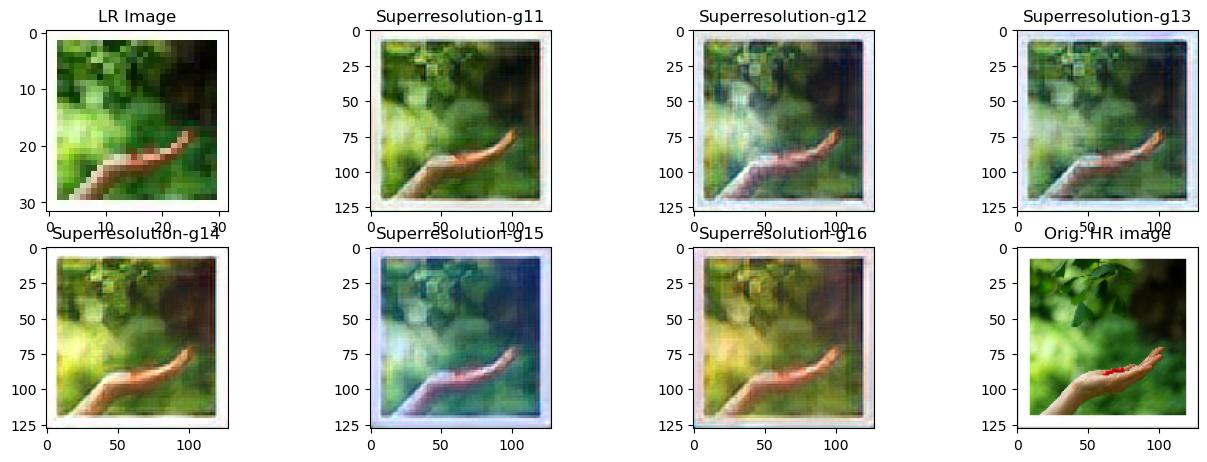

In [38]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator1 = load_model('/Users/akshat/GAN/models/g_11.h5', compile=False)
generator2 = load_model('/Users/akshat/GAN/models/g_12.h5', compile=False)
generator3 = load_model('/Users/akshat/GAN/models/g_13.h5', compile=False)
generator4 = load_model('/Users/akshat/GAN/models/g_14.h5', compile=False)
generator5 = load_model('/Users/akshat/GAN/models/g_15.h5', compile=False)
generator6 = load_model('/Users/akshat/GAN/models/g_16.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
#ix=[29]
src_image, tar_image = X1[ix], X2[ix]
print(ix)
# generate image from source
gen_image1 = generator1.predict(src_image)
gen_image2 = generator2.predict(src_image)
gen_image3 = generator3.predict(src_image)
gen_image4 = generator4.predict(src_image)
gen_image5 = generator5.predict(src_image)
gen_image6 = generator6.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(341)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(342)
plt.title('Superresolution-g11')
plt.imshow(gen_image1[0,:,:,:])
plt.subplot(343)
plt.title('Superresolution-g12')
plt.imshow(gen_image2[0,:,:,:])
plt.subplot(344)
plt.title('Superresolution-g13')
plt.imshow(gen_image3[0,:,:,:])
plt.subplot(345)
plt.title('Superresolution-g14')
plt.imshow(gen_image4[0,:,:,:])
plt.subplot(346)
plt.title('Superresolution-g15')
plt.imshow(gen_image5[0,:,:,:])
plt.subplot(347)
plt.title('Superresolution-g16')
plt.imshow(gen_image6[0,:,:,:])
plt.subplot(348)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])


plt.show()


[30]
(32, 32, 3)
(1, 32, 32, 3)
1/1 [==============================] - 1s 525ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


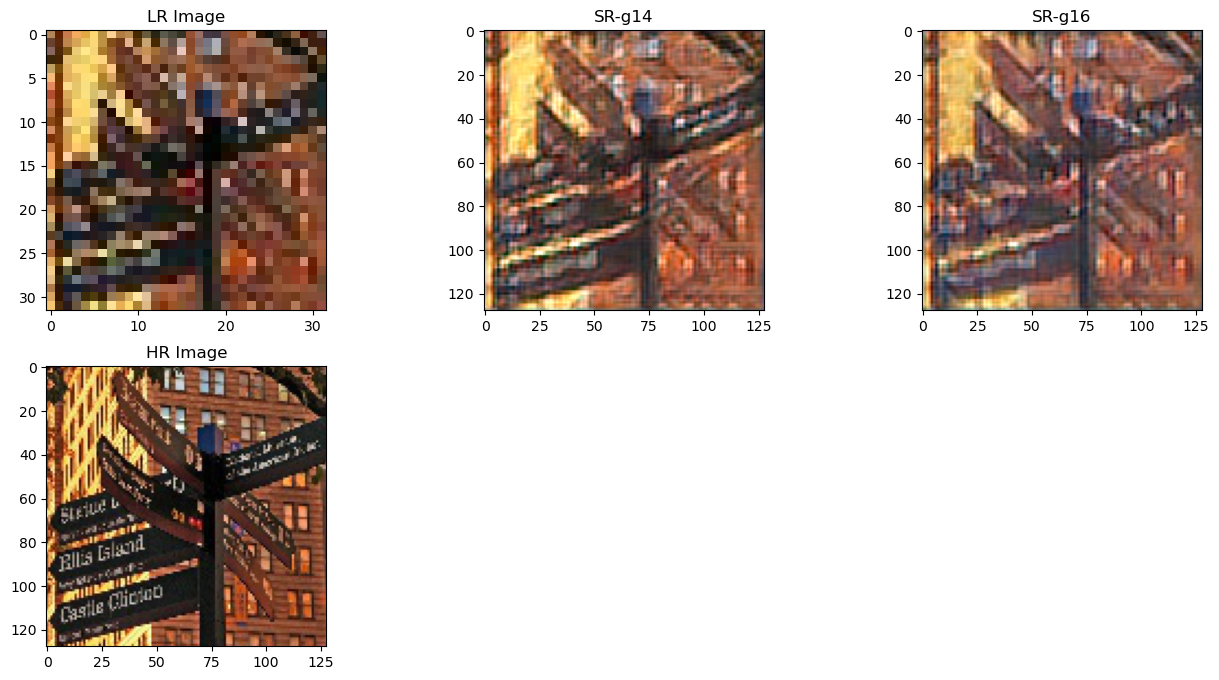

In [82]:
from keras.models import load_model
from numpy.random import randint


g1= load_model('/Users/akshat/GAN/models/g_14.h5', compile=False)
g2 = load_model('/Users/akshat/GAN/models/g_16.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
print(ix)

# generate image from source

gen_image1= g1.predict(src_image)
gen_image2= g2.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('SR-g14')
plt.imshow(gen_image1[0,:,:,:])
plt.subplot(233)
plt.title('SR-g16')
plt.imshow(gen_image2[0,:,:,:])
plt.subplot(234)
plt.title('HR Image')
plt.imshow(tar_image[0,:,:,:])



plt.show()

In [62]:
img_lr = cv2.imread("/Users/akshat/Downloads/cute-baby-animals-1558535060.jpg")
img_lr = cv2.resize(img_lr, (32, 32))
cv2.imwrite("/Users/akshat/Downloads/lr.jpg", img_lr)
img_hr = cv2.imread("/Users/akshat/Downloads/cute-baby-animals-1558535060.jpg")
img_hr = cv2.resize(img_hr, (128, 128))
cv2.imwrite("/Users/akshat/Downloads/hr.jpg", img_hr)

True

(1, 32, 32, 3)
(1, 128, 128, 3)
1/1 [==============================] - 1s 549ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


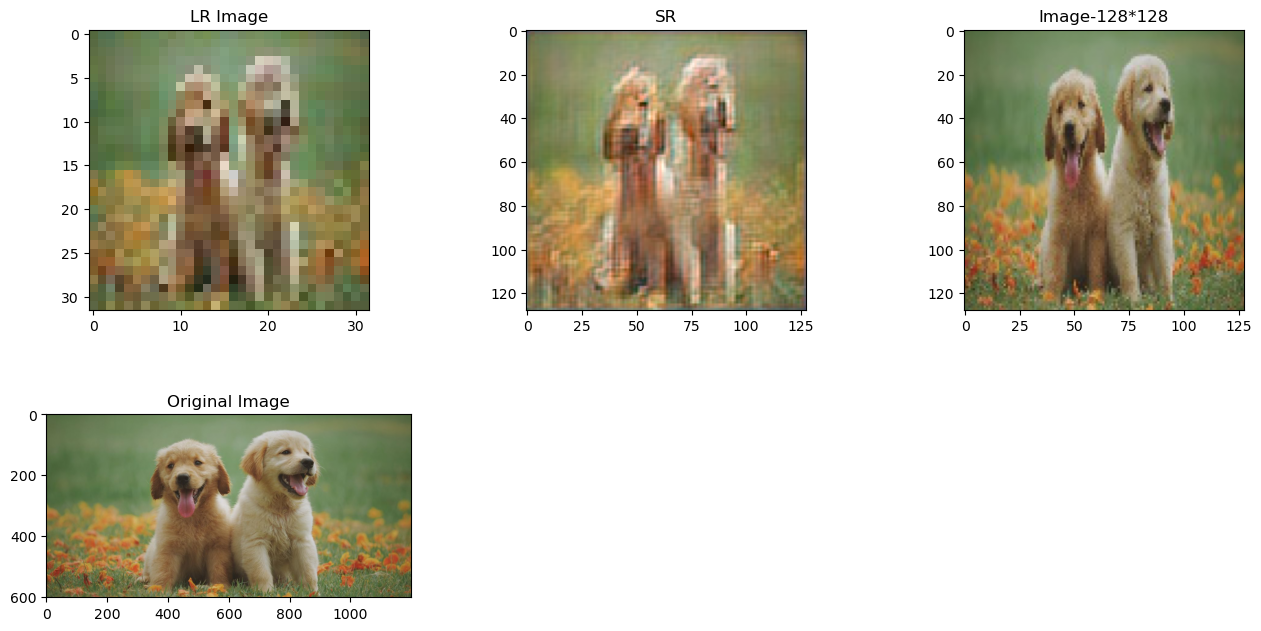

In [98]:
img_lr = cv2.imread("/Users/akshat/Downloads/lr.jpg")
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
img_lr = np.array(img_lr)
img_lr = img_lr/255
img_lr = np.expand_dims(img_lr, axis=0)
print(img_lr.shape)

img_hr = cv2.imread("/Users/akshat/Downloads/hr.jpg")
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
img_hr = np.array(img_hr)
img_hr = img_hr/255
img_hr = np.expand_dims(img_hr, axis=0)
print(img_hr.shape)

img = cv2.imread("/Users/akshat/Downloads/cute-baby-animals-1558535060.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img)
img = img/255

gen= load_model('/Users/akshat/GAN/models/g_14.h5', compile=False)
gen_image= gen.predict(img_lr)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(img_lr[0,:,:,:])
plt.subplot(232)
plt.title('SR')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Image-128*128')
plt.imshow(img_hr[0,:,:,:])
plt.subplot(234)
plt.title('Original Image')
plt.imshow(img)